In [1]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)  # LSTM模型

    def forward(self, x, hidden):
        x, hidden = self.lstm(x, hidden)
        return hidden  # 只需要输出hidden

class Decoder(nn.Module):
    def __init__(self, output_size, hidden_size, num_layers):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(output_size, hidden_size, num_layers)  # LSTM模型
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        x, state = self.lstm(x, hidden)
        x = self.linear(x)
        return x, state

In [2]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, encoder_inputs, decoder_inputs):
        return self.decoder(decoder_inputs, self.encoder(encoder_inputs))

In [3]:
import random

# 数据集生成
soundmark = ['ei', 'bi:', 'si:', 'di:', 'i:', 'ef', 'dʒi:', 'eitʃ', 'ai', 'dʒei', 'kei', 'el', 'em',
             'en', 'əʊ', 'pi:', 'kju:', 'ɑː', 'es', 'ti:', 'ju:', 'vi:', 'dʌblju:', 'eks', 'wai', 'zed']

alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q',
            'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

t = 10000  # 总条数
r = 0.9  # 拟动项
seq_len = 6
src_tokens, tgt_tokens = [], []  # 原始序列、目标序列列表

for i in range(t):
    src, tgt = [], []
    for j in range(seq_len):
        ind = random.randint(0, 25)
        src.append(soundmark[ind])
        if random.random() < r:
            tgt.append(alphabet[ind])
        else:
            tgt.append(alphabet[random.randint(0, 25)])
    src_tokens.append(src)
    tgt_tokens.append(tgt)

src_tokens[:2], tgt_tokens[:2]

([['i:', 'wai', 'ai', 'bi:', 'dʒi:', 'ai'],
  ['ei', 'dʒei', 'bi:', 'zed', 'əʊ', 'ai']],
 [['e', 'y', 'i', 'b', 'g', 'i'], ['a', 'j', 'b', 'z', 'o', 'i']])

In [4]:
from collections import Counter

flatten = lambda l: [item for sublist in l for item in sublist]  # 展平数组

# 构建词表
class Vocab:
    def __init__(self, tokens):
        self.tokens = tokens  # 传入的tokens是二维列表
        self.token2index = {'<bos>': 0, '<eos>': 1}  # 先存好特殊词元
        # 将词元按词频排序后生成列表
        self.token2index.update({
            token: index + 2
            for index, (token, freq) in enumerate(
                sorted(Counter(flatten(self.tokens)).items(), key=lambda x: x[1], reverse=True)
            )
        })
        # 构建id到词元字典
        self.index2token = {index: token for token, index in self.token2index.items()}
    
    def __getitem__(self, query):
        # 单一索引
        if isinstance(query, (str, int)):
            if isinstance(query, str):
                return self.token2index.get(query, 0)
            elif isinstance(query, (int)):
                return self.index2token.get(query, '<unk>')
        # 数组索引
        elif isinstance(query, (list, tuple)):
            return [self.__getitem__(item) for item in query]

    def __len__(self):
        return len(self.index2token)

In [5]:
from torch.utils.data import DataLoader, TensorDataset

#实例化source和target词表
src_vocab, tgt_vocab = Vocab(src_tokens), Vocab(tgt_tokens)

#增加结尾标识<eos>
src_data = torch.tensor([src_vocab[line + ['<eos>']] for line in src_tokens])
tgt_data = torch.tensor([tgt_vocab[line + ['<eos>']] for line in tgt_tokens])

# 训练集和测试集比例8:2, batch_size = 16
train_size = int(len(src_data) * 0.8)
test_size = len(src_data) - train_size
batch_size = 16

train_loader = DataLoader(TensorDataset(src_data[:train_size], tgt_data[:train_size]), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(src_data[-test_size:], tgt_data[-test_size:]), batch_size=1)

In [6]:
# 定义编码器
class Encoder(nn.Module):

    def __init__(self, vocab_size, ebd_size, hidden_size, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, ebd_size)  # 将token表示为embedding
        self.gru = nn.GRU(ebd_size, hidden_size, num_layers=num_layers)

    def forward(self, encoder_inputs):
        # encoder_inputs从(batch_size, seq_len)变成(batch_size, seq_len, emb_size)再调整为(seq_len, batch_siz
        encoder_inputs = self.embedding(encoder_inputs).permute(1, 0, 2)
        output, hidden = self.gru(encoder_inputs)
        # hidden 的形状为 (num_layers, batch_size, hidden_size)
        # 最后时刻的隐层状态即为上下文向量
        return hidden

class Decoder(nn.Module):
    def __init__(self, vocab_size, ebd_size, hidden_size, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, ebd_size)
        # 拼接维度ebd_size + hidden_size
        self.gru = nn.GRU(ebd_size + hidden_size, hidden_size, num_layers=num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, decoder_inputs, encoder_states):
        '''
        decoder_inputs 为目标序列偏移一位的结果，由初始形状：(batch_size, seq_len)变为(batch_size, seq_len, emb_size)
        再调整为(batch_size, seq_len, emb_size) -> (seq_len, batch_size, emb_size)
        '''
        decoder_inputs = self.embedding(decoder_inputs).permute(1, 0, 2)
        context = encoder_states[-1]  # 上下文向量取编码器的最后一个隐层的输出
        # context 初始形状为 (batch_size, hidden_size)
        context = context.repeat(decoder_inputs.shape[0], 1, 1)
        output, hidden = self.gru(torch.cat((decoder_inputs, context), -1), encoder_states)
        # logits 的形状为 (seq_len, batch_size, vocab_size)
        logits = self.linear(output)
        return logits, hidden

In [7]:
# seq2seq模型
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, encoder_inputs, decoder_inputs):
        return self.decoder(decoder_inputs, self.encoder(encoder_inputs))

In [14]:
from tqdm import *
import matplotlib.pyplot as plt

# 设置超参数
lr = 0.001
num_epochs = 20
hidden_size = 128

# 建立模型
encoder = Encoder(len(src_vocab), len(src_vocab), hidden_size, num_layers=2)
decoder = Decoder(len(tgt_vocab), len(tgt_vocab), hidden_size, num_layers=2)
model = Seq2Seq(encoder, decoder)

# 交叉熵损失和Adam优化器
criterion = nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# 记录损失变化
loss_history = []

In [16]:
# 开始训练
model.train()
for epoch in tqdm(range(num_epochs)):
    for encoder_inputs, decoder_targets in train_loader:
        encoder_inputs, decoder_targets = encoder_inputs, decoder_targets
        # 偏移一位作为decoder的输入
        # decoder的输入第一位是<bos>
        bos_column = torch.tensor([tgt_vocab['<bos>']] * decoder_targets.shape[0]).reshape(-1, 1)
        decoder_inputs = torch.cat((bos_column, decoder_targets[:, :-1]), dim=1)
        # pred的形状为 (seq_len, batch_size, vocab_size)
        pred, _ = model(encoder_inputs, decoder_inputs)
        # decoder_targets 的形状为 (batch_size, seq_len)，我们需要改变pred的形状以保证它能够正确输入
        # loss 的形状为 (batch_size, seq_len)，其中的每个元素都代表了一个词元的损失
        loss = criterion(pred.permute(1, 2, 0), decoder_targets).mean()
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:58<00:00,  5.91s/it]


Text(0, 0.5, 'train loss')

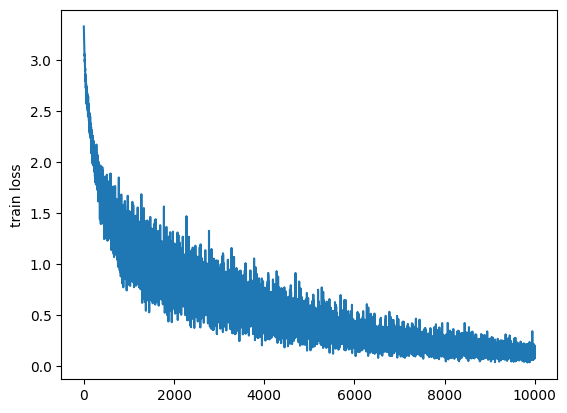

In [17]:
# Plotting the loss history
plt.plot(loss_history)
plt.ylabel('train loss')

In [18]:
model.eval()
translation_results = []

correct = 0
error = 0
# 因为batch_size是1, 所以每次取出来的都是单个句子
for src_seq, tgt_seq in test_loader:
    encoder_inputs = src_seq
    hidden = model.encoder(encoder_inputs)
    pred_seq = [tgt_vocab['<bos>']]
    for _ in range(8):
        # 一步步输出，decoder的输入的形状为(batch_size, seq_len)=(1,1)
        decoder_inputs = torch.tensor(pred_seq[-1]).reshape(1, 1)
        # pred形状为 (seq_len, batch_size, vocab_size) = (1, 1, vocab_size)
        pred, hidden = model.decoder(decoder_inputs, hidden)
        next_token_index = pred.squeeze().argmax().item()
        if next_token_index == tgt_vocab['<eos>']:
            break
        pred_seq.append(next_token_index)

    # 去掉开头的<bos>
    pred_seq = tgt_vocab[pred_seq[1:]]
    # 因为tgt_seq的形状为(1, seq_len), 我们需要将其转化成(seq_len,)的形状
    tgt_seq = tgt_seq.squeeze().tolist()
    
    # 需要注意在<eos>之前截断
    if tgt_vocab['<eos>'] in tgt_seq:
        eos_idx = tgt_seq.index(tgt_vocab['<eos>'])
        tgt_seq = tgt_vocab[tgt_seq[:eos_idx]]
    else:
        tgt_seq = tgt_vocab[tgt_seq]
    
    translation_results.append((' '.join(tgt_seq), ' '.join(pred_seq)))
    
    for i in range(len(tgt_seq)):
        if i >= len(pred_seq) or pred_seq[i] != tgt_seq[i]:
            error += 1
        else:
            correct += 1

print(correct/(correct+error))

0.45116666666666666


In [19]:
translation_results

[('h o t q v o', 'h m t q j'),
 ('y q d m a z', 'y q v a z a'),
 ('a f x g z z', 'a p x c z n'),
 ('i l c w z x', 'i c l w z a'),
 ('q e j h e o', 'q e j h c b'),
 ('p h h x v e', 'p h w o s'),
 ('s t n o s m', 'x t n o i w'),
 ('b r w m n r', 'r q m n p'),
 ('b q p i g c', 'b q z a i c'),
 ('d w g u r p', 'd w g l d a'),
 ('c q h c a z', 'c q h u z y'),
 ('f j n g r j', 'f j n g d'),
 ('v v n p b s', 'v v n b p k'),
 ('s q r i d p', 's q z r n q'),
 ('b u x y d o', 'b u y z s j'),
 ('v x z q c a', 'v s z v a n'),
 ('o q q d a c', 'v q d q c h'),
 ('g v v k y i', 'g v v y k n'),
 ('o m m v s i', 'o m z e i n'),
 ('p j s c w u', 'p s a u y w'),
 ('n c z l r m', 'k c l z p n'),
 ('u z z s s x', 'u z z s p r'),
 ('z v i r s w', 'z v i r p y'),
 ('v c b z y u', 'v b z b n i'),
 ('v f u c l c', 'y f u y w l'),
 ('o t z k d v', 'b t k o i n'),
 ('q r r l a t', 'q o r n g z'),
 ('w w x k k w', 'w t x a z j'),
 ('q e s p y o', 'v p m n z p'),
 ('t m t t v w', 't t m z v a'),
 ('v i t z w o', '